---
# COVID19 death rates South Africa
---

#### Get data from:

COVID-19 Data Repository by the Center for Systems Science and Engineering (CSSE) at Johns Hopkins University


https://github.com/CSSEGISandData/COVID-19.git

In [1]:
%%bash
#git clone https://github.com/CSSEGISandData/COVID-19.git
#cd COVID-19/
#git status COVID-19/
#git pull
#git status COVID-19/

In [2]:
%%capture
%%bash
rm -rf time_series_covid19_*
wget https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv
wget https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import statsmodels.api as sm
import time
from tabulate import tabulate

#### Date and time

In [4]:
print(f'It is now {time.ctime()} GMT+2')

It is now Sat Jul 11 11:15:17 2020 GMT+2


---

### Confirmed cases and deaths

---

In [5]:
# confirmed
country = 'South Africa'
confirmedGlobal = pd.read_csv("time_series_covid19_confirmed_global.csv")
confirmedSA = confirmedGlobal[confirmedGlobal['Country/Region'] == country]
confirmedSA = confirmedSA.drop(['Province/State', 'Country/Region', 'Lat', 'Long'], axis=1)
confirmedSA = pd.DataFrame(confirmedSA.sum(axis=0))
confirmedSA = confirmedSA.reset_index()
confirmedSA.columns = ['Date', 'Confirmed']
confirmedSA['Date'] = pd.to_datetime(confirmedSA['Date'], format='%m/%d/%y')

# Deaths
deathsGlobal = pd.read_csv("time_series_covid19_deaths_global.csv")
deathsSA = deathsGlobal[deathsGlobal['Country/Region'] == country]
deathsSA = deathsSA.drop(['Province/State', 'Country/Region', 'Lat', 'Long'], axis=1)
deathsSA = pd.DataFrame(deathsSA.sum(axis=0))
deathsSA = deathsSA.reset_index()
deathsSA.columns = ['Date', 'Deaths']
deathsSA['Date'] = pd.to_datetime(deathsSA['Date'], format='%m/%d/%y')


#### Table of last 5 rows

In [6]:
# merge

SAdf = pd.merge(confirmedSA, deathsSA)

#Remove the first zero values from the confirmed column
SAdf = SAdf[SAdf['Confirmed'] > 0]

SAdf['DaysFromFirst'] = (SAdf['Date'] - SAdf.iloc[0,0]).dt.days

headers = SAdf.columns

print(tabulate(SAdf.tail(), headers, tablefmt="github"))



|     | Date                |   Confirmed |   Deaths |   DaysFromFirst |
|-----|---------------------|-------------|----------|-----------------|
| 166 | 2020-07-06 00:00:00 |      205721 |     3310 |             123 |
| 167 | 2020-07-07 00:00:00 |      215855 |     3502 |             124 |
| 168 | 2020-07-08 00:00:00 |      224665 |     3602 |             125 |
| 169 | 2020-07-09 00:00:00 |      238339 |     3720 |             126 |
| 170 | 2020-07-10 00:00:00 |      250687 |     3860 |             127 |


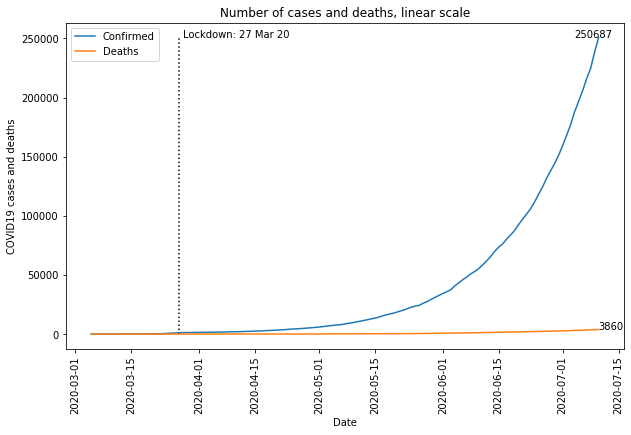

In [7]:
plt.figure(figsize=(10,6))
sns.lineplot(x='Date', y='Confirmed', data=SAdf)
sns.lineplot(x='Date', y='Deaths', data=SAdf)
plt.legend(['Confirmed','Deaths'])
plt.legend(['Confirmed','Deaths'], loc=2)
plt.ylabel("COVID19 cases and deaths")
plt.vlines(x='2020-03-27', ymin=0, ymax=SAdf['Confirmed'].max(), ls="dotted")
plt.text(x='2020-03-28', y=SAdf['Confirmed'].max(), s='Lockdown: 27 Mar 20')
plt.text(x=SAdf.iloc[-7,0], y=SAdf.iloc[-1,1], s=SAdf.iloc[-1,1])
plt.text(x=SAdf.iloc[-1,0], y=SAdf.iloc[-1,2], s=SAdf.iloc[-1,2])
plt.title('Number of cases and deaths, linear scale')
plt.xticks(rotation=90);



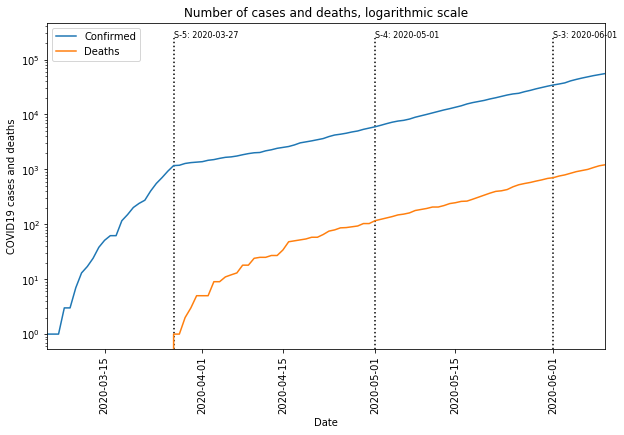

In [8]:
stages = {'S-5': '2020-03-27',
         'S-4': '2020-05-01',
         'S-3': '2020-06-01'}

plt.figure(figsize=(10,6))
sns.lineplot(x='Date', y='Confirmed', data=SAdf)
sns.lineplot(x='Date', y='Deaths', data=SAdf)
plt.legend(['Confirmed','Deaths'], loc=2)
plt.yscale('log')

for stage in stages.keys():
    plt.vlines(x=stages[stage], ymin=0, ymax=SAdf.iloc[-1,1], ls="dotted")
    plt.text(x=stages[stage], y=SAdf.iloc[-1,1], s='{}: {}'.format(stage, stages[stage]), fontsize=8)


plt.xlim(SAdf.iloc[0,0], '2020-06-10')
plt.ylabel("COVID19 cases and deaths")
plt.title('Number of cases and deaths, logarithmic scale')
plt.xticks(rotation=90);

In [9]:
SAdf['Lockdown'] = SAdf['Date'] > '2020-03-27'
SAdf['LogConfirmed'] = np.log10(SAdf['Confirmed'])


In [10]:
mOpen = sm.OLS(SAdf[SAdf['Lockdown'] == False]['LogConfirmed'], 
               SAdf[SAdf['Lockdown'] == False]['DaysFromFirst']).fit()
mClose = sm.OLS(SAdf[SAdf['Lockdown'] == True]['LogConfirmed'], 
               SAdf[SAdf['Lockdown'] == True]['DaysFromFirst']).fit()

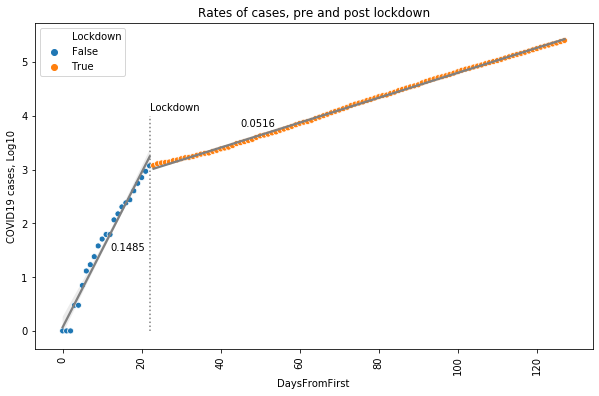

In [11]:
plt.figure(figsize=(10,6))

sns.regplot(x='DaysFromFirst', y='LogConfirmed', data=SAdf[SAdf['Lockdown'] == True], 
            color='grey', marker='')
sns.regplot(x='DaysFromFirst', y='LogConfirmed', data=SAdf[SAdf['Lockdown'] == False], 
            color='grey', marker='')
sns.scatterplot(x='DaysFromFirst', y='LogConfirmed', data=SAdf, hue='Lockdown')
plt.text(12, 1.5, np.round(mOpen.params[0], 4))
plt.text(45, 3.8, np.round(mClose.params[0], 4))
plt.vlines(x=22, ymin=0, ymax=4, linestyles=('dotted'), colors='grey')
plt.text(22, 4.1, 'Lockdown')
plt.ylabel("COVID19 cases, Log10")
plt.title('Rates of cases, pre and post lockdown')
plt.xticks(rotation=90);


---

### Death Rates

---

---
### Model 1
#### Most naive

**The simplest** is to plot deaths against confirmed SARS-COV2 positive people and use the slope to estimate this death rate.

* No account for asymptomatic people
* No adjustment from onset of symptoms to death
* No account for delays in reporting deaths or confirmed cases

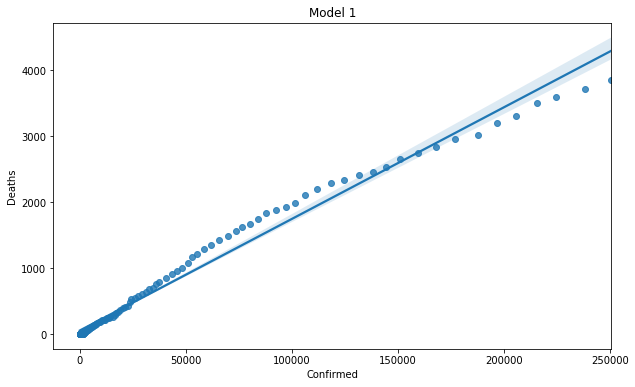

In [12]:
plt.figure(figsize=(10,6))
sns.regplot(x='Confirmed', y='Deaths', data=SAdf)
plt.title('Model 1');

In [13]:
m = sm.OLS(SAdf['Deaths'], SAdf['Confirmed']).fit()
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 Deaths   R-squared (uncentered):                   0.989
Model:                            OLS   Adj. R-squared (uncentered):              0.988
Method:                 Least Squares   F-statistic:                          1.094e+04
Date:                Sat, 11 Jul 2020   Prob (F-statistic):                   4.38e-125
Time:                        11:15:19   Log-Likelihood:                         -808.56
No. Observations:                 128   AIC:                                      1619.
Df Residuals:                     127   BIC:                                      1622.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Confirmed      0.0173      0.000    104.606      0.000       0.017       0.018
==============================================================================
Omnibus:                       17.287   Durbin-Watson:                   0.032
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               45.012
Skew:                          -0.439   Prob(JB):                     1.68e-10
Kurtosis:                       5.769   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [14]:
dr = m.params[0] * 100
print('Using this very simple method we see a death rate of {}%'.format(np.round(dr, 2)))

Using this very simple method we see a death rate of 1.73%


---
### Model 2
#### Second most naive

* No account for asymptomatic people
* No account for delays in reporting deaths or confirmed cases

One of the difficulties in calculating the COVID-19 death rate is that it is hard to know what is the time between a positive test and death.  The test could have been done pre- or post-symptomatic

From: https://www.thelancet.com/journals/laninf/article/PIIS1473-3099(20)30243-7/fulltext

#### Findings

Using data on 24 deaths that occurred in mainland China and 165 recoveries outside of China, we estimated the mean duration from onset of symptoms to death to be 17·8 days (95% credible interval [CrI] 16·9–19·2) and to hospital discharge to be 24·7 days (22·9–28·1). In all laboratory confirmed and clinically diagnosed cases from mainland China (n=70 117), we estimated a crude case fatality ratio (adjusted for censoring) of 3·67% (95% CrI 3·56–3·80). However, after further adjusting for demography and under-ascertainment, we obtained a best estimate of the case fatality ratio in China of 1·38% (1·23–1·53), with substantially higher ratios in older age groups (0·32% [0·27–0·38] in those aged <60 years vs 6·4% [5·7–7·2] in those aged ≥60 years), up to 13·4% (11·2–15·9) in those aged 80 years or older. Estimates of case fatality ratio from international cases stratified by age were consistent with those from China (parametric estimate 1·4% [0·4–3·5] in those aged <60 years [n=360] and 4·5% [1·8–11·1] in those aged ≥60 years [n=151]). Our estimated overall infection fatality ratio for China was 0·66% (0·39–1·33), with an increasing profile with age. Similarly, estimates of the proportion of infected individuals likely to be hospitalised increased with age up to a maximum of 18·4% (11·0–37·6) in those aged 80 years or older.

In [15]:
# a mode may be a better adjustment
days = 18

print(f'Using {days} days in the time adjustment')

Using 18 days in the time adjustment


In [16]:
c = SAdf[['Date','Confirmed']].iloc[0:-days, ]
c.columns = ['testDate', 'Confirmed']
c.reset_index(inplace=True, drop = True)

d = SAdf[['Date','Deaths']].iloc[days:,]
d.columns = ['deathDate', 'Deaths']
d.reset_index(inplace=True, drop = True)

In [17]:
adjSA = pd.concat([c,d], axis=1)
#adjSA.tail()


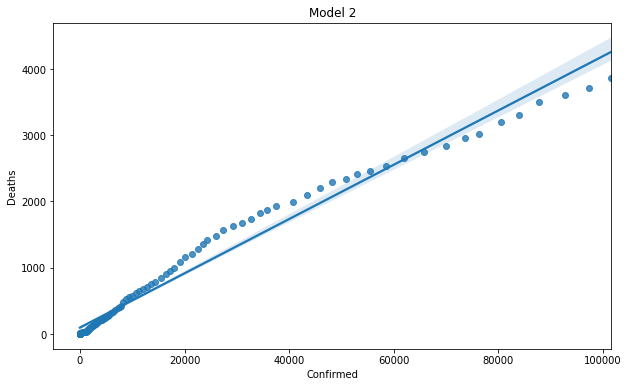

In [18]:
plt.figure(figsize=(10,6))
sns.regplot(x='Confirmed', y='Deaths', data=adjSA, )
plt.title('Model 2');

In [19]:
m = sm.OLS(adjSA['Deaths'], adjSA['Confirmed']).fit()
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 Deaths   R-squared (uncentered):                   0.984
Model:                            OLS   Adj. R-squared (uncentered):              0.983
Method:                 Least Squares   F-statistic:                              6529.
Date:                Sat, 11 Jul 2020   Prob (F-statistic):                    4.20e-99
Time:                        11:15:19   Log-Likelihood:                         -722.91
No. Observations:                 110   AIC:                                      1448.
Df Residuals:                     109   BIC:                                      1451.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Confirmed      0.0427      0.001     80.805      0.000       0.042       0.044
==============================================================================
Omnibus:                        8.822   Durbin-Watson:                   0.022
Prob(Omnibus):                  0.012   Jarque-Bera (JB):               12.617
Skew:                          -0.372   Prob(JB):                      0.00182
Kurtosis:                       4.483   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [20]:
dr = m.params[0] * 100
print('Adjusting for time we find a death rate of {}%'.format(np.round(dr, 2)))

Adjusting for time we find a death rate of 4.27%


---

### Model 3
#### Third most naive

* No account for delays in reporting deaths or confirmed cases
* Couch epidemiology

Use the time adjusted dataframe and adjust for asymptomatic

In [21]:
asym = 0.4

sym = 1 - asym

print(f'Use an asymptomatic rate of {asym * 100}%')

Use an asymptomatic rate of 40.0%


Adjusting for asymptomatic infected people is another difficulty.  

In [22]:
adjSA['Asymptomatic'] = np.floor(adjSA['Confirmed'] * asym / sym)
adjSA['EstTotalInfected'] = adjSA['Confirmed'] + adjSA['Asymptomatic']

headers = adjSA.columns

print(tabulate(adjSA.tail(), headers, tablefmt="github"))

|     | testDate            |   Confirmed | deathDate           |   Deaths |   Asymptomatic |   EstTotalInfected |
|-----|---------------------|-------------|---------------------|----------|----------------|--------------------|
| 105 | 2020-06-18 00:00:00 |       83890 | 2020-07-06 00:00:00 |     3310 |          55926 |             139816 |
| 106 | 2020-06-19 00:00:00 |       87715 | 2020-07-07 00:00:00 |     3502 |          58476 |             146191 |
| 107 | 2020-06-20 00:00:00 |       92681 | 2020-07-08 00:00:00 |     3602 |          61787 |             154468 |
| 108 | 2020-06-21 00:00:00 |       97302 | 2020-07-09 00:00:00 |     3720 |          64868 |             162170 |
| 109 | 2020-06-22 00:00:00 |      101590 | 2020-07-10 00:00:00 |     3860 |          67726 |             169316 |


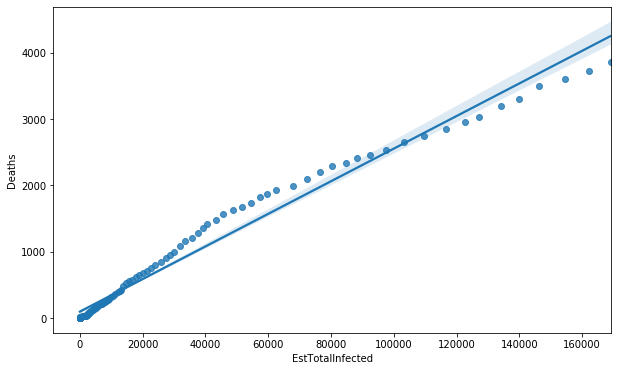

In [23]:
adjSA=adjSA[adjSA['EstTotalInfected'] > 0]
plt.figure(figsize=(10,6))
sns.regplot(x='EstTotalInfected', y='Deaths', data=adjSA);

In [24]:
m = sm.OLS(adjSA['Deaths'], adjSA['EstTotalInfected']).fit()
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 Deaths   R-squared (uncentered):                   0.984
Model:                            OLS   Adj. R-squared (uncentered):              0.983
Method:                 Least Squares   F-statistic:                              6529.
Date:                Sat, 11 Jul 2020   Prob (F-statistic):                    4.21e-99
Time:                        11:15:19   Log-Likelihood:                         -722.91
No. Observations:                 110   AIC:                                      1448.
Df Residuals:                     109   BIC:                                      1451.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
EstTotalInfected     0.0256      0.000     80.803      0.000       0.025       0.026
==============================================================================
Omnibus:                        8.823   Durbin-Watson:                   0.022
Prob(Omnibus):                  0.012   Jarque-Bera (JB):               12.619
Skew:                          -0.372   Prob(JB):                      0.00182
Kurtosis:                       4.484   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [25]:
dr = m.params[0] * 100
print('The death rate adjusting for time and asymtomatic cases is {}%'.format(np.round(dr, 2)))

The death rate adjusting for time and asymtomatic cases is 2.56%


---
Many things not considered

### Daily new

In [26]:
SAdf['NewConfirmed'] = SAdf['Confirmed'].diff()
SAdf['NewDeaths'] = SAdf['Deaths'].diff()

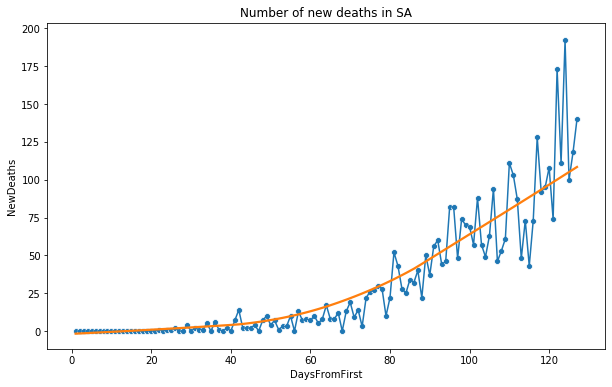

In [27]:
plt.figure(figsize=(10,6))
sns.lineplot(x='DaysFromFirst', y='NewDeaths', data=SAdf)
sns.scatterplot(x='DaysFromFirst', y='NewDeaths', data=SAdf)
sns.regplot(x='DaysFromFirst', y='NewDeaths', data=SAdf, lowess=True, scatter= False)
plt.title('Number of new deaths in SA');

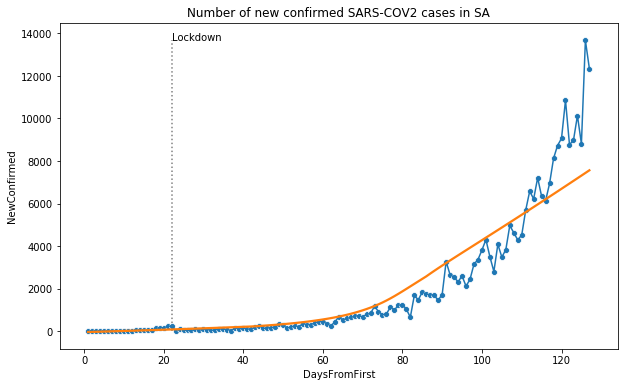

In [28]:
plt.figure(figsize=(10,6))
sns.lineplot(x='DaysFromFirst', y='NewConfirmed', data=SAdf)
sns.scatterplot(x='DaysFromFirst', y='NewConfirmed', data=SAdf)
sns.regplot(x='DaysFromFirst', y='NewConfirmed', data=SAdf, lowess=True, scatter= False)
plt.vlines(x=22, ymin=0, ymax=SAdf['NewConfirmed'].max(), linestyles=('dotted'), colors='grey')
plt.text(22,SAdf['NewConfirmed'].max(), 'Lockdown')
plt.title('Number of new confirmed SARS-COV2 cases in SA');

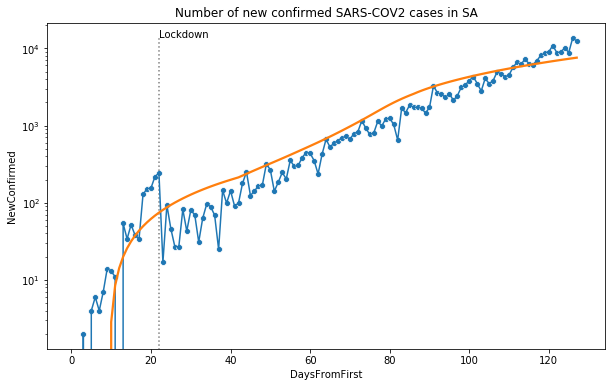

In [29]:
plt.figure(figsize=(10,6))
sns.lineplot(x='DaysFromFirst', y='NewConfirmed', data=SAdf)
sns.scatterplot(x='DaysFromFirst', y='NewConfirmed', data=SAdf)
sns.regplot(x='DaysFromFirst', y='NewConfirmed', data=SAdf, lowess=True, scatter= False)
plt.vlines(x=22, ymin=0, ymax=SAdf['NewConfirmed'].max(), linestyles=('dotted'), colors='grey')
plt.text(22,SAdf['NewConfirmed'].max(), 'Lockdown')
plt.yscale('log')
plt.title('Number of new confirmed SARS-COV2 cases in SA');

---

---